In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
from keras.models import Sequential,load_model,Model
from keras.layers import Conv2D,MaxPool2D,Dense,Dropout,BatchNormalization,Flatten,Input
from sklearn.model_selection import train_test_split
from PIL import Image, ImageOps
import seaborn as sns
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from keras import optimizers
import tensorflow as tensorflow
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping
from keras.callbacks import ReduceLROnPlateau

In [2]:
# cloud based platform - storage, mount the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Replace with your path!
#!unzip -q /content/drive/MyDrive/Datasets/utkface_23k.zip -d data

#/content/drive/MyDrive/Emotion_Detection/archive.zip

#!unzip -q  /content/drive/MyDrive/Emotion_Detection/archive.zip -d  /content/drive/MyDrive/Emotion_Detection/

In [ ]:
#!rm -rf /content/drive/MyDrive/Emotion_Detection/utkface_aligned_cropped/

shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory


# New Section

In [4]:
path = '/content/drive/MyDrive/Emotion_Detection/UTKFace/'
files = os.listdir(path)
size = len(files)
print("Total samples:",size)
#print(files[0])
print(files)

Total samples: 23708
['80_0_0_20170117175515838.jpg.chip.jpg', '73_1_0_20170110140417960.jpg.chip.jpg', '8_1_0_20170109202756111.jpg.chip.jpg', '8_0_0_20170110215400015.jpg.chip.jpg', '83_1_0_20170110181333958.jpg.chip.jpg', '8_1_0_20170109203434803.jpg.chip.jpg', '8_1_0_20170109201110396.jpg.chip.jpg', '8_1_0_20170103200353070.jpg.chip.jpg', '82_0_2_20170111210110290.jpg.chip.jpg', '8_1_0_20170109201746036.jpg.chip.jpg', '77_0_0_20170111222408207.jpg.chip.jpg', '8_0_0_20170110215511548.jpg.chip.jpg', '7_1_1_20170109194708063.jpg.chip.jpg', '7_1_3_20161220222848259.jpg.chip.jpg', '78_1_0_20170120230348881.jpg.chip.jpg', '84_1_0_20170120222457967.jpg.chip.jpg', '85_1_0_20170110184001159.jpg.chip.jpg', '8_0_0_20170110225315590.jpg.chip.jpg', '9_0_0_20170110220536562.jpg.chip.jpg', '9_1_0_20170109203259973.jpg.chip.jpg', '80_1_0_20170110140603775.jpg.chip.jpg', '80_1_0_20170110180237499.jpg.chip.jpg', '75_0_0_20170117174511134.jpg.chip.jpg', '75_1_1_20170105003534605.jpg.chip.jpg', '9_0_0

In [5]:
images = []
ages = []
genders = []

for i in os.listdir(path)[0:10000]:
#for i in os.listdir(path):
    split = i.split('_')
    ages.append(int(split[0]))
    genders.append(int(split[1]))
    images.append(Image.open(path + i))

In [6]:
images = pd.Series(list(images), name = 'Images')
ages = pd.Series(list(ages), name = 'Ages')
genders = pd.Series(list(genders), name = 'Genders')

df = pd.concat([images, ages, genders], axis=1)
df

,Images,Ages,Genders
0,<PIL.JpegImagePlugin.JpegImageFile image mode=...,80,0
1,<PIL.JpegImagePlugin.JpegImageFile image mode=...,73,1
2,<PIL.JpegImagePlugin.JpegImageFile image mode=...,8,1
3,<PIL.JpegImagePlugin.JpegImageFile image mode=...,8,0
4,<PIL.JpegImagePlugin.JpegImageFile image mode=...,83,1
...,...,...,...
9995,<PIL.JpegImagePlugin.JpegImageFile image mode=...,39,1
9996,<PIL.JpegImagePlugin.JpegImageFile image mode=...,38,1
9997,<PIL.JpegImagePlugin.JpegImageFile image mode=...,3,1
9998,<PIL.JpegImagePlugin.JpegImageFile image mode=...,39,1


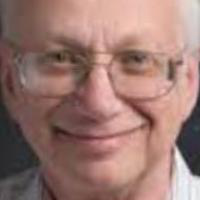

80 0


In [7]:
display(df['Images'][0])
print(df['Ages'][0], df['Genders'][0])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


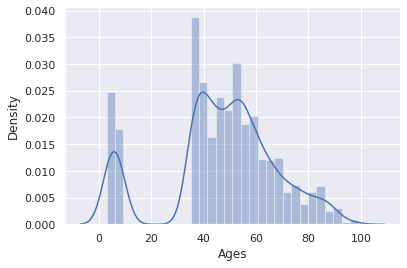

In [8]:
sns.set_theme()
sns.distplot(df['Ages'],kde=True, bins=30)

In [9]:
under4s = []

for i in range(len(df)):
    if df['Ages'].iloc[i] <= 4:
        under4s.append(df.iloc[i])
under4s = pd.DataFrame(under4s)
under4s = under4s.sample(frac=0.3)

df = df[df['Ages'] > 4]

df = pd.concat([df, under4s], ignore_index = True)

In [10]:
df = df[df['Ages'] < 80]

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


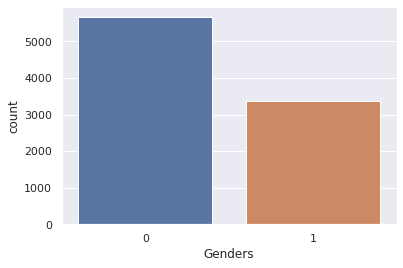

In [11]:
df = df[df['Genders'] != 3]
sns.countplot(df['Genders'])

In [12]:
x = []
y = []

for i in range(len(df)):
    df['Images'].iloc[i] = df['Images'].iloc[i].resize((64,64), Image.ANTIALIAS)
    ar = np.asarray(df['Images'].iloc[i])
    x.append(ar)
    agegen = [int(df['Ages'].iloc[i]), int(df['Genders'].iloc[i])]
    y.append(agegen)
x = np.array(x)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [ ]:
#num_clasess = 7

In [13]:
y_age = df['Ages']
y_gender = df['Genders']
#y_gender = to_categorical(Y_gender, num_classes=2)

x_train_age, x_test_age, y_train_age, y_test_age = train_test_split(x, y_age, test_size=0.2, stratify=y_age)
x_train_gender, x_test_gender, y_train_gender, y_test_gender = train_test_split(x, y_gender, test_size=0.2, stratify=y_gender)

In [14]:
y_age > 100

1       False
2       False
3       False
5       False
6       False
        ...  
9667    False
9668    False
9669    False
9670    False
9671    False
Name: Ages, Length: 9031, dtype: bool

In [15]:
# parameters
batch_size = 32
input_shape = (64, 64, 3)
verbose = 1
num_epochs = 120
patience = 16
base_path = '/content/drive/My Drive/Emotion_Detection/GENDER_AGE/'
l2_regularization=0.001
 

In [ ]:
# model = Sequential()
# input_shape = (64,64,3)
# model.add(Conv2D(96, (5, 5), input_shape=input_shape,activation='relu', padding='same'))

# model.add(Conv2D(96, (5, 5), activation='relu', padding='same'))
# model.add(BatchNormalization()) #to avoid overfitting
# model.add(MaxPooling2D(pool_size=(2, 2)))#MaxPooling2D helps to reduce the size of the data
# model.add(Dropout(0.2)) #Used to prevent a model from overfitting ##  addedd

# model.add(Conv2D(192, (5, 5), activation='relu', padding='same'))
# model.add(Conv2D(192, (5, 5), activation='relu', padding='same'))
# model.add(BatchNormalization()) #to avoid overfitting
# model.add(MaxPooling2D(pool_size=(2, 2)))#MaxPooling2D helps to reduce the size of the data#24X24X64
# model.add(Dropout(0.2)) #Used to prevent a model from overfitting

# model.add(Conv2D(384, (3, 3), activation='relu', padding='same'))
# model.add(Conv2D(384, (3, 3), activation='relu', padding='same'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2)))#MaxPooling2D helps to reduce the size of the data
# model.add(Dropout(0.3)) #Used to prevent a model from overfitting

# model.add(Flatten())#Converts multi dimensional array to 1D channel
# model.add(Dense(192))   ##  changed
# model.add(BatchNormalization())
# model.add(Activation('relu')) #relu activation function added to remove the negative values
# model.add(Dropout(0.2)) #Used to prevent a model from overfitting

# model.add(Dense(1, activation='relu'))

# model.compile(loss='mean_squared_error', optimizer=tensorflow.optimizers.Adam(lr=0.001))



In [ ]:
model = Sequential()
input_shape = (64,64,3)
model.add(Conv2D(32, (5, 5), input_shape=input_shape,activation='relu', padding='same'))

model.add(Conv2D(64, (5, 5), activation='relu', padding='same'))
model.add(BatchNormalization()) #to avoid overfitting
model.add(MaxPooling2D(pool_size=(2, 2)))#MaxPooling2D helps to reduce the size of the data
model.add(Dropout(0.2)) #Used to prevent a model from overfitting ##  addedd

model.add(Conv2D(128, (5, 5), activation='relu', padding='same'))
model.add(BatchNormalization()) #to avoid overfitting
model.add(MaxPooling2D(pool_size=(2, 2)))#MaxPooling2D helps to reduce the size of the data
model.add(Dropout(0.2)) #Used to prevent a model from overfitting

model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))#MaxPooling2D helps to reduce the size of the data
model.add(Dropout(0.2)) #Used to prevent a model from overfitting

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))#MaxPooling2D helps to reduce the size of the data
model.add(Dropout(0.2)) #Used to prevent a model from overfitting

model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))#MaxPooling2D helps to reduce the size of the data

model.add(Flatten())#Converts multi dimensional array to 1D channel

model.add(Dense(128))   ##  changed
model.add(BatchNormalization())

model.add(Activation('relu')) #relu activation function added to remove the negative values
model.add(Dropout(0.2)) #Used to prevent a model from overfitting

model.add(Dense(1, activation='relu'))

#model.compile(loss='mean_squared_error', optimizer=tensorflow.optimizers.Adam(lr=0.001))



In [ ]:
datagen = ImageDataGenerator(
      rescale=1./255., width_shift_range = 0.1, height_shift_range = 0.1, horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale=1./255)

train1 = datagen.flow(x_train_age, y_train_age, batch_size=batch_size)

test1 = test_datagen.flow(x_test_age, y_test_age,batch_size=batch_size)

#model = Model(img_input, output)
model.compile(loss='mean_squared_error',  optimizer=tensorflow.optimizers.Adam(lr=0.001))
#model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_85 (Conv2D)          (None, 64, 64, 32)        2432      
                                                                 
 conv2d_86 (Conv2D)          (None, 64, 64, 64)        51264     
                                                                 
 batch_normalization_75 (Bat  (None, 64, 64, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_54 (MaxPoolin  (None, 32, 32, 64)       0         
 g2D)                                                            
                                                                 
 dropout_66 (Dropout)        (None, 32, 32, 64)        0         
                                                                 
 conv2d_87 (Conv2D)          (None, 32, 32, 128)     

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
#print(x_train_age)

In [ ]:
# callbacks
log_file_path = base_path + 'age_training.log'
csv_logger = CSVLogger(log_file_path, append=False)
early_stop = EarlyStopping('val_loss', patience=patience)
reduce_lr = ReduceLROnPlateau('val_loss', factor=0.1, patience=int(patience/4), verbose=1)
trained_models_path = base_path + 'age_model'
model_names = trained_models_path + '.{epoch:02d}.hdf5'
model_checkpoint = ModelCheckpoint(model_names, 'val_loss', verbose=1,save_best_only=True)
callbacks = [model_checkpoint, csv_logger, early_stop, reduce_lr]

history1 =model.fit(train1,steps_per_epoch=len(x_train_age) / batch_size,epochs=num_epochs, verbose=1, callbacks=callbacks, validation_data=test1)

Epoch 1/120
224/223 [==============================] - ETA: 0s - loss: 243.4958
Epoch 1: val_loss improved from inf to 249.61148, saving model to /content/drive/My Drive/Emotion_Detection/GENDER_AGE/age_model.01.hdf5
223/223 [==============================] - 11s 46ms/step - loss: 243.4958 - val_loss: 249.6115 - lr: 0.0010
Epoch 2/120
223/223 [============================>.] - ETA: 0s - loss: 227.5259
Epoch 2: val_loss improved from 249.61148 to 229.06427, saving model to /content/drive/My Drive/Emotion_Detection/GENDER_AGE/age_model.02.hdf5
223/223 [==============================] - 10s 45ms/step - loss: 227.7557 - val_loss: 229.0643 - lr: 0.0010
Epoch 3/120
224/223 [==============================] - ETA: 0s - loss: 215.8454
Epoch 3: val_loss improved from 229.06427 to 220.84694, saving model to /content/drive/My Drive/Emotion_Detection/GENDER_AGE/age_model.03.hdf5
223/223 [==============================] - 10s 45ms/step - loss: 215.8454 - val_loss: 220.8469 - lr: 0.0010
Epoch 4/120
2

In [ ]:
###  Gender Model

In [22]:
gender_model = Sequential()
input_shape = (64,64,3)
gender_model.add(Conv2D(32, (5, 5), input_shape=input_shape,activation='relu', padding='same'))


gender_model.add(Conv2D(32, (5, 5), activation='relu', padding='same'))

gender_model.add(BatchNormalization()) #to avoid overfitting

gender_model.add(MaxPooling2D(pool_size=(2, 2)))#MaxPooling2D helps to reduce the size of the data
gender_model.add(Dropout(0.3)) #Used to prevent a model from overfitting

gender_model.add(Dropout(0.3)) #Used to prevent a model from overfitting ##  addedd
gender_model.add(Conv2D(64, (5, 5), activation='relu', padding='same'))
gender_model.add(Conv2D(64, (5, 5), activation='relu', padding='same'))

gender_model.add(BatchNormalization()) #to avoid overfitting
gender_model.add(MaxPooling2D(pool_size=(2, 2)))#MaxPooling2D helps to reduce the size of the data
#24X24X64
gender_model.add(Dropout(0.3)) #Used to prevent a model from overfitting

gender_model.add(Conv2D(128, (5, 5), activation='relu', padding='same'))
gender_model.add(Conv2D(128, (5, 5), activation='relu', padding='same'))

gender_model.add(BatchNormalization())
gender_model.add(MaxPooling2D(pool_size=(2, 2)))#MaxPooling2D helps to reduce the size of the data

gender_model.add(Dropout(0.3)) #Used to prevent a model from overfitting
gender_model.add(Flatten())#Converts multi dimensional array to 1D channel
gender_model.add(Dense(64))   ##  changed
gender_model.add(BatchNormalization())
gender_model.add(Activation('relu')) #relu activation function added to remove the negative values
gender_model.add(Dropout(0.2)) #Used to prevent a model from overfitting

gender_model.add(Dense(1, activation='sigmoid'))

#gender_model.compile(loss='binary_crossentropy', optimizer=tensorflow.optimizers.Adam(lr=0.001), metrics=['accuracy'])

In [ ]:
# genmodel = Sequential()
# genmodel.add(Conv2D(32, (3,3), activation='relu', input_shape=(64, 64, 3)))
# genmodel.add(MaxPooling2D((2,2)))
# genmodel.add(Conv2D(64, (3,3), activation='relu'))
# genmodel.add(MaxPooling2D((2,2)))
# genmodel.add(Conv2D(128, (3,3), activation='relu'))
# genmodel.add(MaxPooling2D((2,2)))
# genmodel.add(Flatten())
# # genmodel.add(Dense(64, activation='relu'))
# genmodel.add(Dropout(0.5))
# # genmodel.add(Dense(1, activation='sigmoid'))

# genmodel.compile(loss='binary_crossentropy', optimizer=tensorflow.optimizers.Adam(lr=0.0001),
#              metrics=['accuracy'])

In [23]:
datagen = ImageDataGenerator(
      rescale=1./255., width_shift_range = 0.1, height_shift_range = 0.1, horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale=1./255)

train2 = datagen.flow(x_train_gender, y_train_gender, batch_size=batch_size)

test2 = test_datagen.flow(x_test_gender, y_test_gender,batch_size=batch_size)
gender_model.compile(loss='binary_crossentropy', optimizer=tensorflow.optimizers.Adam(lr=0.001), metrics=['accuracy'])
gender_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 64, 64, 32)        2432      
                                                                 
 conv2d_7 (Conv2D)           (None, 64, 64, 32)        25632     
                                                                 
 batch_normalization_4 (Batc  (None, 64, 64, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 32, 32, 32)        0         
                                                                 
 dropout_6 (Dropout)         (None, 32, 32, 32)       

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [24]:
# callbacks
log_file_path = base_path + 'gender_training.log'
csv_logger = CSVLogger(log_file_path, append=False)
early_stop = EarlyStopping('val_loss', patience=patience)
reduce_lr = ReduceLROnPlateau('val_loss', factor=0.1, patience=int(patience/4), verbose=1)
trained_models_path = base_path + 'gender_model'
model_names = trained_models_path + '.{epoch:02d}.hdf5'
model_checkpoint = ModelCheckpoint(model_names, 'val_loss', verbose=1,save_best_only=True)
callbacks = [model_checkpoint, csv_logger, early_stop, reduce_lr]

history2 =gender_model.fit(train2,steps_per_epoch=len(x_train_gender) / batch_size,
                        epochs=num_epochs, verbose=1, callbacks=callbacks,
                        validation_data=test2)

Epoch 1/120
225/225 [============================>.] - ETA: 0s - loss: 0.5365 - accuracy: 0.7358
Epoch 1: val_loss improved from inf to 0.58251, saving model to /content/drive/My Drive/Emotion_Detection/GENDER_AGE/gender_model.01.hdf5
225/225 [==============================] - 13s 52ms/step - loss: 0.5370 - accuracy: 0.7357 - val_loss: 0.5825 - val_accuracy: 0.6724 - lr: 0.0010
Epoch 2/120
226/225 [==============================] - ETA: 0s - loss: 0.4249 - accuracy: 0.8092
Epoch 2: val_loss improved from 0.58251 to 0.45895, saving model to /content/drive/My Drive/Emotion_Detection/GENDER_AGE/gender_model.02.hdf5
225/225 [==============================] - 11s 51ms/step - loss: 0.4249 - accuracy: 0.8092 - val_loss: 0.4589 - val_accuracy: 0.7687 - lr: 0.0010
Epoch 3/120
225/225 [============================>.] - ETA: 0s - loss: 0.3509 - accuracy: 0.8479
Epoch 3: val_loss improved from 0.45895 to 0.38445, saving model to /content/drive/My Drive/Emotion_Detection/GENDER_AGE/gender_model.03.

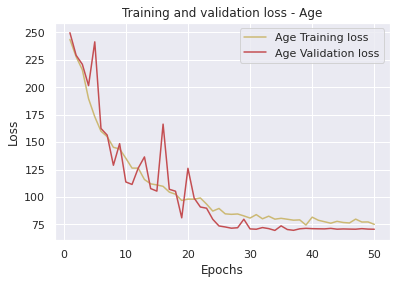

In [ ]:
history = history1

#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Age Training loss')
plt.plot(epochs, val_loss, 'r', label='Age Validation loss')
plt.title('Training and validation loss - Age')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

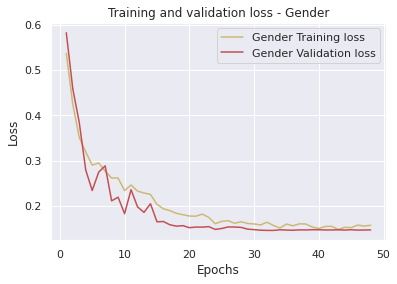

In [25]:
history = history2

#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Gender Training loss')
plt.plot(epochs, val_loss, 'r', label='Gender Validation loss')
plt.title('Training and validation loss - Gender')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [26]:
acc = history.history['accuracy']
#acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
#val_acc = history.history['val_accuracy']

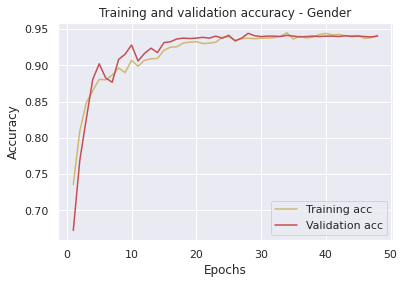

In [27]:
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy - Gender')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()